In [ ]:
!pip install -r requirements.txt

In [1]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

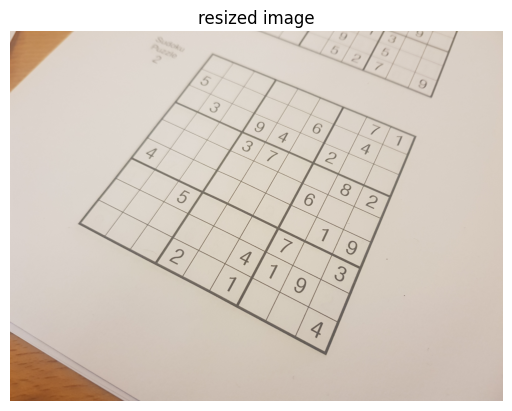

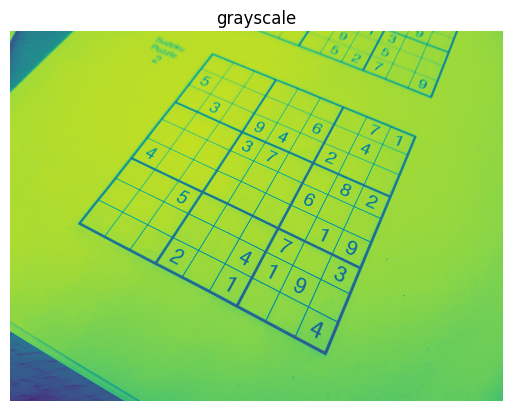

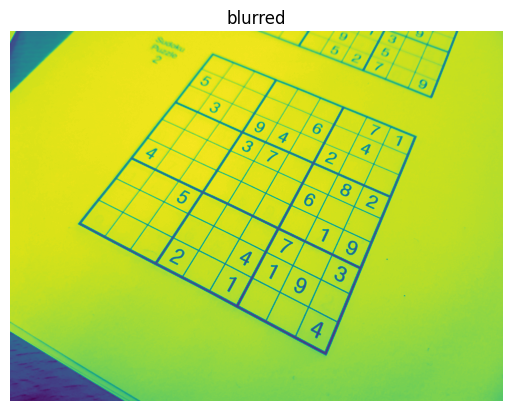

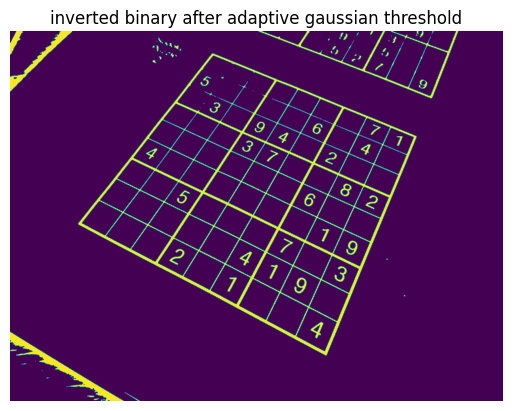

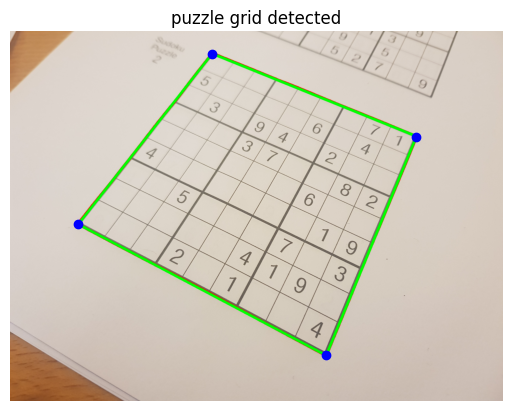

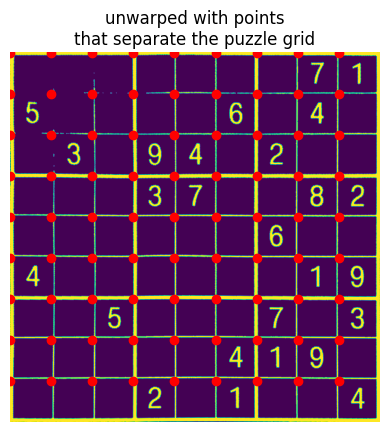

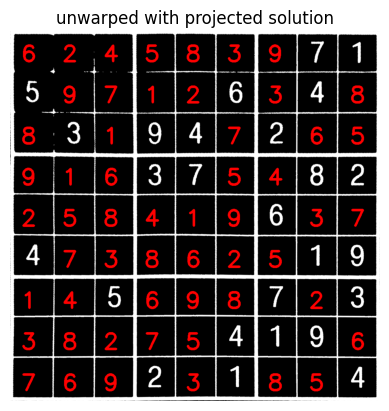

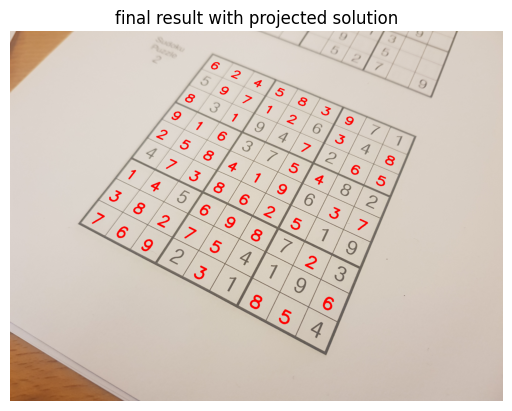

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


##################################
# GRID VALUES EXTRACTION AND OCR #
##################################

def imshow(image, title):
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')


def extract_values_from_puzzle(image, dim):
    # resize to ensure our chosen parameters work
    big_dim = 2 * dim
    if image.shape[0] > image.shape[1]:
        shape = (big_dim, int(big_dim / image.shape[0] * image.shape[1]), image.shape[2])
    else:
        shape = (int(big_dim / image.shape[1] * image.shape[0]), big_dim, image.shape[2])
    resized_image = cv2.resize(image, (shape[1], shape[0]), interpolation=cv2.INTER_LINEAR)
    imshow(resized_image, 'resized image')

    # to grayscale
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    imshow(gray_image, 'grayscale')

    # preprocess with low-pass 2d filter before threshold (useful for computer screen photos, where pixel edges are visible)
    blurred_image = cv2.blur(gray_image, (4, 4))
    imshow(blurred_image, 'blurred')

    # use adaptive gaussian threshold to create a binary image
    binary_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 301, 20)
    # imshow(binary_image, 'binary image')

    # invert binary image
    inverted_image = 255 - binary_image
    imshow(inverted_image, 'inverted binary after adaptive gaussian threshold')

    # extract the largest contour in the image
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    picture_with_contours = resized_image.copy()
    cv2.drawContours(picture_with_contours, [largest_contour], -1, (255, 0, 0), 10)

    # extract the largest contour approximation that has four points and edges (the puzzle grid area square)
    epsilon = 0.1 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    cv2.drawContours(picture_with_contours, [approx], -1, (0, 255, 0), 10)
    imshow(picture_with_contours, 'puzzle grid detected')
    plt.scatter(approx[:, 0, 0], approx[:, 0, 1], color='b', marker='o')

    # switch point order in case the image is rotated in the 'wrong' direction
    if approx[1, 0, 1] < approx[3, 0, 1]:
        approx = np.array([approx[1, 0, :], approx[2, 0, :], approx[3, 0, :], approx[0, 0, :]])

    # find the homography that transforms the image into a square shape
    target_square_corner_points = np.array([[[0, 0]], [[0, dim - 1]], [[dim - 1, dim - 1]], [[dim - 1, 0]]])
    homo, _ = cv2.findHomography(approx, target_square_corner_points)
    unwarped_image = cv2.warpPerspective(inverted_image, homo, (dim, dim))
    imshow(unwarped_image, 'unwarped with points\nthat separate the puzzle grid')

    # find the points that separate the puzzle grid
    points = []
    for i in range(0, dim, int(dim / 9)):
        for ii in range(0, dim, int(dim / 9)):
            points.append([i, ii])
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], color='r', marker='o')

    # cut out individual grid elements (a.k.a. fields)
    edge_cut = 20
    edge_add = 4
    fields = []
    for i in range(0, len(points)):
        field = unwarped_image[points[i, 0] + edge_cut: points[i, 0] + int(dim / 9) - edge_cut,
                points[i, 1] + edge_cut: points[i, 1] + int(dim / 9) - edge_cut]
        # stretch digit to whole surface
        contours, _ = cv2.findContours(field, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        stretched = np.zeros(field.shape)
        if len(contours):
            largest_contour = max(contours, key=cv2.contourArea)
            if cv2.contourArea(largest_contour) > 100:
                x, y, w, h = cv2.boundingRect(largest_contour)
                small_homo, _ = cv2.findHomography(
                    np.array([[x, y], [x + w - 1, y], [x, y + h - 1], [x + w - 1, y + h - 1]]),
                    np.array([[edge_add, edge_add],
                              [field.shape[0] - edge_add - 1, edge_add],
                              [edge_add, field.shape[1] - edge_add - 1],
                              [field.shape[0] - edge_add - 1, field.shape[1] - edge_add - 1]]))
                stretched_contour = []
                for ii in range(0, len(largest_contour)):
                    dot = np.dot(small_homo, [largest_contour[ii][0][0], largest_contour[ii][0][1], 1])
                    stretched_contour.append([[int(round(dot[0])), int(round(dot[1]))]])
                stretched_contour = np.array(stretched_contour)
                cv2.drawContours(stretched, [stretched_contour], -1, (255, 0, 0), 3)
        fields.append(stretched)

    # save fields to .png files (we use these for optical character recognition)
    for i in range(0, len(fields)):
        cv2.imwrite('./pics/fields/' + str(i) + '.png', fields[i] * 255)

    # we manually renamed the field images and saved them into the digits folder
    # we load those nine digits and empty field (zero)
    digits = []
    for i in range(0, 10):
        digit = (cv2.imread('./pics/digits/' + str(i) + '.png', cv2.IMREAD_GRAYSCALE) / 255).astype(int)
        digits.append(digit)

    # homebrew simple optical character recognition
    values = []
    for i in range(0, len(fields)):
        sums = []
        for ii in range(0, len(digits)):
            product = np.multiply(fields[i], digits[ii])
            sums.append(np.sum(product))
        values.append(np.argmax(sums))
    visual_values = np.array(values).reshape((9, 9))
    # print(visual_values)

    # we convert to string for further processing (finding the solution to the puzzle)
    values_as_string = ''.join(map(str, values))
    return resized_image, unwarped_image, visual_values, values_as_string, homo


##################################
#         PUZZLE SOVLING         #
# https://norvig.com/sudoku.html #
##################################

def cross(a, b):
    # cross product of elements in a and elements in b
    return [aa + bb for aa in a for bb in b]


digits = '123456789'
rows = 'ABCDEFGHI'
cols = digits
squares = cross(rows, cols)
unit_list = ([cross(rows, c) for c in cols] +
             [cross(r, cols) for r in rows] +
             [cross(rs, cs) for rs in ('ABC', 'DEF', 'GHI') for cs in ('123', '456', '789')])
units = dict((s, [u for u in unit_list if s in u])
             for s in squares)
peers = dict((s, set(sum(units[s], [])) - {s})
             for s in squares)


def eliminate(values, s, d):
    # eliminate d from values[s]; propagate when values or places <= 2
    # return values, except return False if a contradiction is detected
    if d not in values[s]:
        return values  # already eliminated
    values[s] = values[s].replace(d, '')
    # (1) if a square s is reduced to one value d2, then eliminate d2 from the peers
    if len(values[s]) == 0:
        return False  # contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminate(values, s2, d2) for s2 in peers[s]):
            return False
    # (2) if a unit u is reduced to only one place for a value d, then put it there
    for u in units[s]:
        d_places = [s for s in u if d in values[s]]
        if len(d_places) == 0:
            return False  # contradiction: no place for this value
        elif len(d_places) == 1:
            # d can only be in one place in unit; assign it there
            if not assign(values, d_places[0], d):
                return False
    return values


def grid_values(grid):
    # convert grid into a dict of {square: char} with '0' or '.' for empties
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))


def assign(values, s, d):
    # eliminate all the other values (except d) from values[s] and propagate
    # return values, except return False if a contradiction is detected
    other_values = values[s].replace(d, '')
    if all(eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False


def parse_grid(grid):
    # convert grid to a dict of possible values, {square: digits},
    # or return False if a contradiction is detected
    # to start, every square can be any digit; then assign values from the grid
    values = dict((s, digits) for s in squares)
    for s, d in grid_values(grid).items():
        if d in digits and not assign(values, s, d):
            return False  # (fail if we can't assign d to square s.)
    return values


def display(values):
    # display these values as a 2d grid
    width = 1 + max(len(values[s]) for s in squares)
    line = '+'.join(['-' * (width * 3)] * 3)
    for r in rows:
        print(''.join(values[r + c].center(width) + ('|' if c in '36' else '')
                      for c in cols))
        if r in 'CF': print(line)
    print()


def some(seq):
    # return some element of seq that is true
    for e in seq:
        if e:
            return e
    return False


def search(values):
    # using depth-first search and propagation, try all possible values
    if values is False:
        return False  # failed earlier
    if all(len(values[s]) == 1 for s in squares):
        return values  # solved!
    # chose the unfilled square s with the fewest possibilities
    n, s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    return some(search(assign(values.copy(), s, d))
                for d in values[s])


def solve(grid):
    return search(parse_grid(grid))


#######################################
# PROCESS PUZZLE AND PROJECT SOLUTION #
#######################################

def process_puzzle(image):
    # convert to RGB
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # extract the grid values (digits) from the image
    dim = 999
    resized_image, unwarped_image, visual_values, values_as_string, homo = extract_values_from_puzzle(rgb, dim)

    # solve the sudoku puzzle
    solved = solve(values_as_string)

    # show the final state of internal structure
    # display(solved)

    # transform solution to array of arrays
    solution = []
    for _, v in solved.items():
        solution.append(v)
    nine_by_nine_solution = np.array(solution).reshape((9, 9))

    # project the final solution onto the original image
    unwarped_image = cv2.cvtColor(unwarped_image, cv2.COLOR_GRAY2RGB)
    mask = np.zeros((unwarped_image.shape[0], unwarped_image.shape[1]), dtype=np.uint8)
    for i in range(0, 9):
        for ii in range(1, 10):
            if visual_values[ii - 1, i] == 0:
                cv2.putText(unwarped_image, str(nine_by_nine_solution[ii - 1, i]),
                            (i * int(dim / 9) + 30, ii * int(dim / 9) - 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 5)
                cv2.putText(mask, str(nine_by_nine_solution[ii - 1, i]),
                            (i * int(dim / 9) + 30, ii * int(dim / 9) - 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (1, 1, 1), 5)
    imshow(unwarped_image, 'unwarped with projected solution')

    inverse_homo = np.linalg.inv(homo)
    big_mask = cv2.warpPerspective(mask, inverse_homo, (resized_image.shape[1], resized_image.shape[0])) * 255
    inverse_mask = cv2.bitwise_not(big_mask)
    deleted_part = cv2.bitwise_and(resized_image, resized_image, mask=inverse_mask)
    big_red = np.zeros(resized_image.shape, dtype=np.uint8)
    big_red[:, :, 0] = big_mask
    final_picture = cv2.add(deleted_part, big_red)
    imshow(final_picture, 'final result with projected solution')


########
# MAIN #
########

# process_puzzle(cv2.imread('./pics/puzzles/ideal.png'))
# process_puzzle(cv2.imread('./pics/puzzles/wild-paper-1.jpg'))
# process_puzzle(cv2.imread('./pics/puzzles/wild-paper-2.jpg'))
process_puzzle(cv2.imread('./pics/puzzles/wild-paper-3.jpg'))
# process_puzzle(cv2.imread('./pics/puzzles/wild-paper-4.jpg'))
# process_puzzle(cv2.imread('./pics/puzzles/wild-screen.jpg'))